In [1]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from trans import *
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

In [2]:
data = Dataset('data/transcriptions/train.csv')
words_vocab = data.words_vocab
trans_vocab = data.trans_vocab

In [10]:
class DotAttention(nn.Module):
    def __init__(self):
        super(DotAttention, self).__init__()
    
    def forward(self, outputs, hidden, mask = None):
        '''
        Inputs:
            outputs: (batch x seq_len x hidden_size) - outputs of encoder
            hidden:  (batch x hidden_size)           - last hidden state of decoder
            mask:    (batch x seq_len x 1)           - mask of non-padded words (1=word, 0=padding)
        Outputs:
            ### weights: (batch x seq_len x 1)
            context: (batch x hidden_size)
        '''
        hidden        = hidden.unsqueeze(-1)           #b x hidden x 1
        logits = outputs.matmul(hidden)                #b x seq_len x 1
        if mask is not None:
            logits.masked_fill_(1-mask, -float('inf')) #b x seq_len x 1
        weights       = F.softmax(logits, dim=1)       #b x seq_len x 1
        context       = (weights*outputs).sum(dim = 1) #b x seq_len x 1

        return context
    
class GeneralAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GeneralAttention, self).__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, outputs, hidden, mask = None):
        '''
        Inputs:
            outputs: (batch x seq_len x hidden_size) - outputs of encoder
            hidden:  (batch x hidden_size)           - last hidden state of decoder
            mask:    (batch x seq_len x 1)           - mask of non-padded words (1=word, 0=padding)
        Outputs:
            ### weights: (batch x seq_len x 1)
            context: (batch x hidden_size)
        '''        
        hidden        = hidden.unsqueeze(-1)                  #b x hidden x 1
        lin_outputs   = self.linear1(outputs)                 #b x seq_len x hidden
        weight_logits = lin_outputs.matmul(hidden)            #b x seq_len x 1
        if mask is not None:
            weight_logits.masked_fill_(1-mask, -float('inf')) #b x seq_len x 1
        weights       = F.softmax(weight_logits, dim=1)       #b x seq_len x 1
        context       = (weights*outputs).sum(dim = 1)        #b x hidden
        
        return context
    

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.linear1 = nn.Linear(2*hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, outputs, hidden, mask = None):
        '''
        Inputs:
            outputs: (batch x seq_len x hidden_size) - outputs of encoder
            hidden:  (batch x hidden_size)           - last hidden state of decoder
            mask:    (batch x seq_len x 1)           - mask of non-padded words (1=word, 0=padding)
        Outputs:
            ### weights: (batch x seq_len x 1)
            context: (batch x hidden_size)
        '''
        hidden  = hidden.unsqueeze(1)                  #b x 1 x hidden
        hidden  = hidden.repeat(1, outputs.size(1), 1) #b x seq_len x hidden
        hidden  = torch.cat([hidden, outputs], dim=-1) #b x seq_len x 2*hidden
        w       = self.linear1(hidden)                 #b x seq_len x hidden
        tanw    = F.tanh(w)                            #b x seq_len x hidden
        logits  = self.linear2(tanw)                   #b x seq_len x 1
        if mask is not None:
            logits.masked_fill_(1-mask, -float('inf')) #b x seq_len x 1
        weights = F.softmax(logits, dim=1)             #b x seq_len x 1
        
        context = (weights*outputs).sum(dim = 1)
        return context

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru       = nn.GRU(emb_size, hidden_size, batch_first=True)
    
    def forward(self, source, source_lens=None):
        embedded = self.embedding(source)
        if source_lens is not None:
            embedded = pack(embedded, source_lens, batch_first=True)
        outs, hidden = self.gru(embedded)
        
        if source_lens is not None:
            outs, _ = unpack(outs, batch_first = True)
        return outs, hidden
    
        
class DecoderCell(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx, attention_type=None):
        super(DecoderCell, self).__init__()
        
        
        self.emb_size    = emb_size
        self.hidden_size = hidden_size
        
        self.embedding   = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        if attention_type is None:
            self.gru_cell = nn.GRUCell(emb_size, hidden_size)
        else:
            self.gru_cell = nn.GRUCell(emb_size+hidden_size, hidden_size)
        self.linear_out  = nn.Linear(hidden_size, vocab_size)
    
        assert attention_type in [None, 'dot', 'general', 'bahdanau']
        self.attention = None
        if attention_type == 'dot':
            self.attention = DotAttention()
        elif attention_type == 'general':
            self.attention = GeneralAttention(hidden_size)
        elif attention_type == 'bahdanau':
            self.attention = BahdanauAttention(hidden_size)
            
    def forward(self, target, outputs, hidden, mask_attention = None):
        '''
        Inputs:
            target:  (batch x 1)
            outputs: (batch x seq_len x hidden_size)
            hidden:  (batch x hidden_size)
            mask:    (batch x seq_len x 1)   - mask of non-padded words (1=word, 0=padding)
        Outputs:
            logit:  (batch x vocab_size)
            hidden: (batch x hidden_size)
        '''
        batch_size  = target.size()[0]
        embedded    = self.embedding(target).squeeze(1)               #b x embedding_size 
        if self.attention is None:
            hidden  = self.gru_cell(embedded, hidden)                 #b x hidden_size
        else:
            context = self.attention(outputs, hidden, mask_attention) #b x hidden_size
            x_t     = torch.cat([embedded, context], dim=1)           #b x embedding_size+hidden_size
            hidden  = self.gru_cell(x_t, hidden)                      #b x hidden_size
        logit       = self.linear_out(hidden)                         #b x vocab_size
        return logit, hidden
    
    
    
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, len_in_vocab, len_out_vocab, 
                 in_pad_idx=0, out_pad_idx=0, attention_type=None):
        
        super(Model, self).__init__()        
        self.encoder = Encoder(len_in_vocab, emb_size, hidden_size, in_pad_idx)
        self.decoder = DecoderCell(len_out_vocab, emb_size, hidden_size, out_pad_idx, attention_type)
        self.len_trans_vocab = len_out_vocab
        
    def forward(self, batch_words, words_lens, batch_trans_in, mask_attention = None):
        outputs, hidden = self.encoder(batch_words, words_lens)
        hidden = hidden.squeeze() #1 x b x hidden -> b x hidden        
        logits = []
        for i in range(batch_trans_in.size(1)):
            # can init first decoder cell w/ hidden = 0; if attention works correctly, it should be fine
            logit, hidden = self.decoder(batch_trans_in[:, i].unsqueeze(1), outputs, hidden, mask_attention)
            logits.append(logit)
        logits = torch.stack(logits, 1)
        logits = logits.view(-1, self.len_trans_vocab)
        return logits
    
    def generate(self, bos_idx, eos_idx, batch_words, words_lens, mask_attention = None):
        '''
        Inputs:
            bos_idx:        int
            eos_idx:        int
            batch_words:    (batch(1) x enc_seq_len)
            words_lens:     (batch(1))
            mask_attention: (batch(1) x seq_len x 1) - mask of non-padded words (1=word, 0=padding)
        Outputs:
            logit:  (batch x vocab_size)
            hidden: (batch x hidden_size)
        '''
        with torch.no_grad():
            inp = [bos_idx]
            outputs, hidden = self.encoder(batch_words, words_lens) #b x seq_len x hidden, 1 x b x hidden
            hidden = hidden.squeeze(0)                              #b x hidden
            for _ in range(100):
                inp_tensor = torch.LongTensor([[inp[-1]]]).to(batch_words.device) #b(1) x 1
                logits, hidden   = self.decoder(inp_tensor, outputs, hidden, mask_attention)

                next_token = F.softmax(logits, dim=-1)[-1].topk(1)[1].item()
                inp.append(next_token)
                if next_token == eos_idx:
                    break
            return inp

In [13]:
# тестим Attention
outputs = torch.randn(32, 12, 24)
hidden  = torch.randn(32, 24)
attention = BahdanauAttention(24)
a = attention(outputs, hidden)
a.size()

/home/rustem/.virtualenvs/dl/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([32, 24])

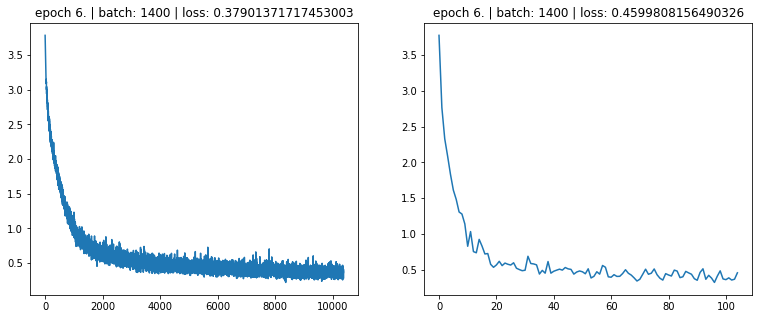

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder    = Encoder(len(words_vocab), 32, 64, words_vocab.pad_idx)
decoder    = DecoderCell(len(trans_vocab), 32, 64, words_vocab.pad_idx, 'dot')
model      = Model(32, 64, len(words_vocab), len(trans_vocab),\
                  words_vocab.pad_idx, trans_vocab.pad_idx, 'dot').to(device)
optimizer  = optim.Adam(model.parameters())
criterion  = nn.CrossEntropyLoss()
batch_size = 64
num_epochs = 7

trainer   = Trainer(model, data, optimizer, criterion)
trainer.train(num_epochs, batch_size)

In [8]:
def _print(val):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(1, sort=True, val=True)
    batch_words     = batch_words.to(device)
    words_lens      = words_lens.to(device)
    batch_trans_out = batch_trans_out.to(device)
    mask_attention  = (batch_words != data.words_vocab.pad_idx).unsqueeze(-1)

    inp = model.generate(data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words, words_lens, mask_attention)

    tokens = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
                                                                       data.trans_vocab.eos_idx,
                                                                       data.trans_vocab.pad_idx]]
    print('Src: ', ''.join([data.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    print('Real:', ''.join([data.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [data.trans_vocab.sos_idx,
                                                                            data.trans_vocab.eos_idx,
                                                                            data.trans_vocab.pad_idx]]))

In [15]:
for _ in range(10):
    _print(True)
    print()

Src:  GILBY
Pred: JHIHLBIY
Real: GIHLBIY

Src:  ALOISI
Pred: AALOWSIY
Real: AALOYSIY

Src:  HASHED
Pred: HHAESHT
Real: HHAESHT

Src:  CLOSEUP
Pred: KLAOZUWAHP
Real: KLOWSAHP

Src:  BERNHAGEN
Pred: BERNHHEHGAHN
Real: BERNHHAHGAHN

Src:  LACHMAR
Pred: LAEKMER
Real: LAEKMAAR

Src:  HOTALING'S
Pred: HHAATAHLIHNGZ
Real: HHAATAHLIHNGZ

Src:  AUTHORING
Pred: AOTHERIYIHNG
Real: AATHERIHNG

Src:  BILELLO
Pred: BIHLEHLOW
Real: BIHLEHLOW

Src:  PHOEBUS
Pred: FOWBAHS
Real: FIYBAHS

